Load needed libraries

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install opencv-contrib-python==4.4.0.44

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
from shapely.geometry import box,mapping
from scipy.interpolate import interp1d
from skimage.feature import peak_local_max
import scipy.ndimage.filters as filters
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

STEP B: 
Test on scene image: {m1.png, m2.png, m3.png, m4.png, m5.png}  

Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 26.jpg, 25.jpg}

In [ ]:
scene_paths = ["h1.jpg", "h2.jpg", "h3.jpg", "h4.jpg", "h5.jpg"]
model_paths = ["{}.jpg".format(i) for i in range(23)]


def load_images(paths,dir):
  return [cv2.cvtColor(cv2.imread("/content/gdrive/My Drive/CV Project/"+dir+path),cv2.COLOR_BGR2RGB) for path in paths]
  
# Load scene and model images
train_images = load_images(scene_paths,"scenes/")
query_images = load_images(model_paths,"models/")
query_images_smoothed = [cv2.GaussianBlur(img,(5,5),0) for img in query_images]
train_images_smoothed = [cv2.GaussianBlur(img,(5,5),0) for img in train_images]
# Compute keypoints and descriptors
sift = cv2.SIFT_create()

train_features = {index:sift.detectAndCompute(train_image,None) for index,train_image in enumerate(train_images)}
query_features = {index:sift.detectAndCompute(query_image,None) for index,query_image in enumerate(query_images)}
query_features_smoothed = {index:sift.detectAndCompute(query_image,None) for index,query_image in enumerate(query_images_smoothed)}
train_features_smoothed = {index:sift.detectAndCompute(train_image,None) for index,train_image in enumerate(train_images_smoothed)}

In [ ]:
def compute_matches(FLANN_INDEX_KDTREE,trees,checks,k,lowe,des_train,des_query):
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = trees)
  search_params = dict(checks = checks)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  matches = flann.knnMatch(des_query,des_train,k=2)
  # store all the good matches as per Lowe's ratio test.
  good = []
  for m,n in matches:
      if m.distance < lowe*n.distance:
          good.append(m)
  return good

def get_roi(x1,x2,x3,x4,y1,y2,y3,y4,img):
  top_left_x = int(max(0,min([x1,x2,x3,x4])))
  top_left_y = int(max(0, min([y1,y2,y3,y4])))
  bot_right_x = int(max([x1,x2,x3,x4]))
  bot_right_y = int(max([y1,y2,y3,y4]))
  return (img[top_left_y:bot_right_y, top_left_x:bot_right_x],(top_left_x,top_left_y),(bot_right_x,bot_right_y))

# Function to compute IOU value over the two input rectangles
def bb_intersection_over_union(rectangleA, rectangleB):
      intersection = rectangleA.intersection(rectangleB).area
      union = rectangleA.union(rectangleB).area
      if intersection and union:
        return intersection / union
      else:
        return 0

# Function to check dimension's consistency and overlaps between rectangles
def non_maxima_suppression(rectangles, IOU_THRES = 0.15, MIN_DIAG = 80, MAX_DIAG = 700):
  x_dims = np.array([end[0] - start[0] for start,end in rectangles])
  y_dims = np.array([end[1] - start[1] for start,end in rectangles])
  filtered_rectangles = []
  for index in range(len(rectangles)):
    if x_dims[index] >= 50 and x_dims[index] <= 80:
      if y_dims[index] >= 70 and y_dims[index] <= 120:
        filtered_rectangles.append(rectangles[index])
  rectangles = filtered_rectangles
  if len(rectangles):
    polygons = [box(start[0], start[1], end[0],end[1]) for start,end in rectangles]
    maxima = []
    polygons.sort(key=lambda x: x.area, reverse=True)
    for index,poly in enumerate(polygons):
      found = False
      for poly_2 in maxima:
        if bb_intersection_over_union(poly,poly_2) >= IOU_THRES or bb_intersection_over_union(poly_2,poly) >= IOU_THRES:
          found = True
      if not found:
         maxima.append(poly)   
    return maxima
  else:
     return []

# Compute features and votes for each keypoint
def compute_feature_vector(query_kp,train_kp,train_shape,N_HORIZONTAL_BINS = 25,N_VERTICAL_BINS = 25):
  query_xy = np.array([kp.pt for kp in query_kp])
  train_xy = np.array([kp.pt for kp in train_kp])
  N_HORIZONTAL_BINS = train_shape[1] // 20
  N_VERTICAL_BINS = train_shape[0] // 50
  # Baricenter of matched query keypoints 
  bary_x,bary_y = query_xy.mean(axis = 0)
  scale_ratio = np.array([kp_t.size / kp_q.size for kp_t,kp_q in zip(train_kp,query_kp)])
  angle_diff = np.array([kp_t.angle - kp_q.angle for kp_t,kp_q in zip(train_kp,query_kp)])
  Vx_i = np.array(query_xy[:,0] - bary_x)
  Vy_i = np.array(query_xy[:,1] - bary_y)
  pred_bary_x = train_xy[:,0] + scale_ratio * (np.cos(angle_diff) * Vx_i - np.sin(angle_diff) * Vy_i)
  pred_bary_y = train_xy[:,1] + scale_ratio * (np.sin(angle_diff) * Vx_i - np.cos(angle_diff) * Vy_i)
  interp_x = interp1d([0,train_shape[1]],[0,N_HORIZONTAL_BINS])
  interp_y = interp1d([0,train_shape[0]],[0,N_VERTICAL_BINS])
  votes_x = [int(interp_x(pred_x)) if pred_x >= 0 and pred_x <= train_shape[1] else -1 for pred_x in pred_bary_x]
  votes_y = [int(interp_y(pred_y)) if pred_y >= 0 and pred_y <= train_shape[0] else -1 for pred_y in pred_bary_y]
  votes = {}
  votes_matrix = np.zeros((N_VERTICAL_BINS,N_HORIZONTAL_BINS))
  for index,(votes_x,votes_y) in enumerate(zip(votes_x,votes_y)):
    if votes_x >= 0 and votes_y >= 0:
      votes.setdefault((votes_y,votes_x),[]).append((train_kp[index],query_kp[index]))
      votes_matrix[votes_y,votes_x] += 1
  return (votes,votes_matrix)

# Grab the neighbours of the input index
def grab_neigh_indexes(max_index):
  neigh_indexes = []
  for i in range(-2,3):
    for j in range(-3,4):
      neigh_indexes.append((max_index[0] + i,max_index[1] + j))
  return neigh_indexes

# Print the output and draw the bounding box and centroids
def print_output(query_idx,rectangles,img_train):
    print("Product {} - {} Instances Found:".format(query_idx,len(rectangles)))
    for index in range(len(rectangles)):
        centroid = rectangles[index].centroid
        bounding_box = mapping(rectangles[index])["coordinates"]
        width = int(bounding_box[0][1][0]) - int(bounding_box[0][3][0])
        height = int(bounding_box[0][1][1]) - int(bounding_box[0][3][1])
        cv2.rectangle(img_train, (int(bounding_box[0][3][0]),int(bounding_box[0][3][1])), (int(bounding_box[0][1][0]),int(bounding_box[0][1][1])), (0,255,0), thickness = 5)
        cv2.circle(img_train, (int(centroid.xy[0][0]),int(centroid.xy[1][0])), radius=5, color=(0, 255, 0), thickness=-1)
        print("Instance {} [ position: (({},{}), width: {} px, height: {} px]".format(query_idx,centroid.xy[0][0],centroid.xy[1][0],width,height))

    return len(rectangles)


Product 1 - 1 Instances Found:
Instance 1 [ position: ((294.0,41.0), width: 54 px, height: 82 px]
Product 2 - 2 Instances Found:
Instance 2 [ position: ((35.5,108.5), width: 71 px, height: 93 px]
Instance 2 [ position: ((106.0,110.0), width: 66 px, height: 94 px]
Product 3 - 2 Instances Found:
Instance 3 [ position: ((269.5,401.0), width: 75 px, height: 102 px]
Instance 3 [ position: ((337.0,402.5), width: 70 px, height: 95 px]
Product 4 - 2 Instances Found:
Instance 4 [ position: ((228.5,101.5), width: 79 px, height: 109 px]
Instance 4 [ position: ((165.0,102.5), width: 78 px, height: 105 px]
Product 5 - 2 Instances Found:
Instance 5 [ position: ((310.5,81.0), width: 67 px, height: 90 px]
Instance 5 [ position: ((368.5,99.5), width: 59 px, height: 83 px]
Product 7 - 2 Instances Found:
Instance 7 [ position: ((495.0,109.0), width: 70 px, height: 104 px]
Instance 7 [ position: ((120.0,452.5), width: 58 px, height: 73 px]
Product 8 - 1 Instances Found:
Instance 8 [ position: ((423.0,229.

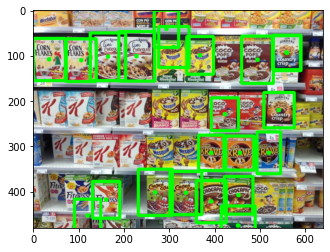

Product 2 - 3 Instances Found:
Instance 2 [ position: ((36.0,58.0), width: 72 px, height: 116 px]
Instance 2 [ position: ((32.0,212.0), width: 64 px, height: 92 px]
Instance 2 [ position: ((146.5,360.0), width: 73 px, height: 80 px]
Product 3 - 2 Instances Found:
Instance 3 [ position: ((299.0,426.0), width: 76 px, height: 84 px]
Instance 3 [ position: ((360.5,422.5), width: 69 px, height: 79 px]
Product 4 - 4 Instances Found:
Instance 4 [ position: ((202.5,136.0), width: 77 px, height: 100 px]
Instance 4 [ position: ((594.5,48.0), width: 79 px, height: 96 px]
Instance 4 [ position: ((143.5,127.5), width: 73 px, height: 103 px]
Instance 4 [ position: ((577.5,383.5), width: 65 px, height: 81 px]
Product 5 - 2 Instances Found:
Instance 5 [ position: ((303.5,318.5), width: 63 px, height: 93 px]
Instance 5 [ position: ((271.0,114.5), width: 54 px, height: 83 px]
Product 6 - 1 Instances Found:
Instance 6 [ position: ((125.0,396.5), width: 66 px, height: 119 px]
Product 7 - 1 Instances Found

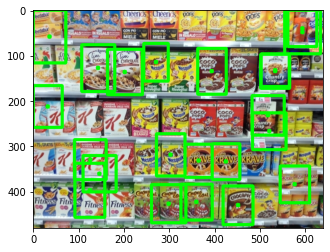

Product 1 - 1 Instances Found:
Instance 1 [ position: ((580.5,321.0), width: 71 px, height: 78 px]
Product 2 - 2 Instances Found:
Instance 2 [ position: ((141.5,138.0), width: 75 px, height: 76 px]
Instance 2 [ position: ((251.0,284.5), width: 56 px, height: 73 px]
Product 3 - 2 Instances Found:
Instance 3 [ position: ((447.0,414.0), width: 78 px, height: 88 px]
Instance 3 [ position: ((344.5,398.5), width: 59 px, height: 93 px]
Product 4 - 2 Instances Found:
Instance 4 [ position: ((306.0,114.5), width: 76 px, height: 107 px]
Instance 4 [ position: ((241.5,118.5), width: 67 px, height: 95 px]
Product 5 - 2 Instances Found:
Instance 5 [ position: ((362.5,120.5), width: 63 px, height: 91 px]
Instance 5 [ position: ((433.0,104.0), width: 54 px, height: 72 px]
Product 6 - 1 Instances Found:
Instance 6 [ position: ((288.5,248.5), width: 61 px, height: 103 px]
Product 7 - 3 Instances Found:
Instance 7 [ position: ((495.0,125.0), width: 72 px, height: 114 px]
Instance 7 [ position: ((565.0,1

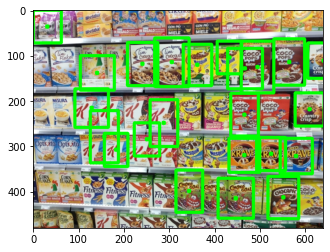

Product 2 - 1 Instances Found:
Instance 2 [ position: ((84.5,130.5), width: 71 px, height: 97 px]
Product 3 - 1 Instances Found:
Instance 3 [ position: ((267.5,435.5), width: 75 px, height: 99 px]
Product 4 - 2 Instances Found:
Instance 4 [ position: ((148.5,122.0), width: 79 px, height: 112 px]
Instance 4 [ position: ((212.5,125.0), width: 77 px, height: 114 px]
Product 5 - 3 Instances Found:
Instance 5 [ position: ((376.0,50.0), width: 62 px, height: 100 px]
Instance 5 [ position: ((350.5,125.0), width: 65 px, height: 90 px]
Instance 5 [ position: ((291.5,136.5), width: 59 px, height: 99 px]
Product 7 - 1 Instances Found:
Instance 7 [ position: ((421.0,128.5), width: 66 px, height: 101 px]
Product 9 - 1 Instances Found:
Instance 9 [ position: ((78.5,332.5), width: 61 px, height: 103 px]
Product 11 - 2 Instances Found:
Instance 11 [ position: ((446.0,337.0), width: 60 px, height: 78 px]
Instance 11 [ position: ((388.5,336.5), width: 61 px, height: 75 px]
Product 13 - 2 Instances Found

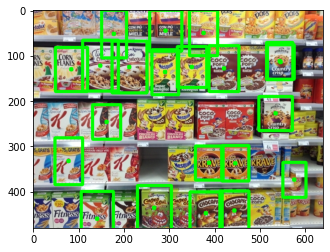

Product 0 - 1 Instances Found:
Instance 0 [ position: ((65.0,279.5), width: 74 px, height: 73 px]
Product 1 - 1 Instances Found:
Instance 1 [ position: ((478.5,422.0), width: 65 px, height: 96 px]
Product 2 - 1 Instances Found:
Instance 2 [ position: ((173.5,491.5), width: 51 px, height: 81 px]
Product 3 - 3 Instances Found:
Instance 3 [ position: ((273.0,433.5), width: 72 px, height: 111 px]
Instance 3 [ position: ((338.5,444.5), width: 63 px, height: 87 px]
Instance 3 [ position: ((217.5,443.0), width: 65 px, height: 84 px]
Product 4 - 3 Instances Found:
Instance 4 [ position: ((99.5,132.0), width: 77 px, height: 106 px]
Instance 4 [ position: ((165.5,135.5), width: 77 px, height: 103 px]
Instance 4 [ position: ((358.0,130.0), width: 50 px, height: 78 px]
Product 5 - 3 Instances Found:
Instance 5 [ position: ((276.5,151.5), width: 77 px, height: 115 px]
Instance 5 [ position: ((465.5,468.5), width: 69 px, height: 95 px]
Instance 5 [ position: ((234.5,112.5), width: 65 px, height: 81 

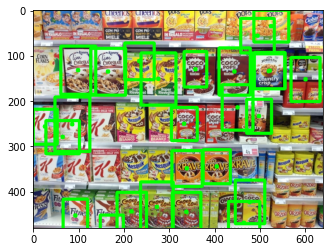

In [ ]:
def object_retrieve(query_idx,img_query, img_train, query_features, train_features, min_match_count = 0, COLOR_DIFF_THRESHOLD = 55, verbose = False):
    rectangles = []
    key_train,des_train = np.array(train_features[0]),np.array(train_features[1])
    key_query,des_query = np.array(query_features[0]),np.array(query_features[1])
    good = compute_matches(0,5,50,2,0.95,des_train,des_query)
    # If it's a good match, then proceed with the detection
    if len(good)>min_match_count:
       query_pts = np.array([key_query[m.queryIdx] for m in good ])
       train_pts = np.array([key_train[m.trainIdx] for m in good ])
       # Fetch votes dictionary and accumulator votes matrix
       votes,votes_matrix = compute_feature_vector(query_pts,train_pts, img_train.shape)
       # Get local maxima in the accumulator matrix
       data_max = filters.maximum_filter(votes_matrix, (2,2))
       indexes = np.where(data_max == votes_matrix, votes_matrix, 0)
       indexes = [(row[0],row[1])for row in np.argwhere(indexes > 0)]
       # For each local maxima found, compute the homography
       for index in indexes:
        if votes_matrix[index] >= 1:
          neigh_indexes = grab_neigh_indexes(index)
          neigh_votes = [vote for index in neigh_indexes for vote in votes.get(index,[])]
          src_points = np.float32([vote[1].pt for vote in neigh_votes]).reshape(-1,1,2)
          dst_points = np.float32([vote[0].pt for vote in neigh_votes]).reshape(-1,1,2)
          if len(src_points) >= 4:
            M, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 0.5)
            if M is None:
                pass
            else:
              # A rectangle was generated: We need to check it's dimension and color
                h,w,_ = img_query.shape
                # Generate and plot the rectangle into the target image
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                dst = cv2.perspectiveTransform(pts,M)
                roi,start,end = get_roi(dst[0][0][0],dst[1][0][0],dst[2][0][0],dst[3][0][0],dst[0][0][1],dst[1][0][1],dst[2][0][1],dst[3][0][1],img_train)
                # If we can manage to obtain a rectangle, then we proceed
                if len(roi):
                  # check if the euclidean distance between the colors (mean) of the two rectangle is lower than the chosen threshold
                  color_diff = np.linalg.norm(roi.mean(axis = 0).mean(axis = 0) - img_query.mean(axis = 0).mean(axis = 0))
                  if color_diff <= COLOR_DIFF_THRESHOLD: 
                    rectangles.append((start,end))
    #Check the rectangle's dimension and if it overlaps with another
    rectangles = non_maxima_suppression(np.array(rectangles))
    # Draw the bounding box and center pixel of every blob
    if len(rectangles):
      print_output(query_idx,rectangles,img_train)
    return rectangles


pred_labels = {}
#Iterating among all scenes and looking for the query object.
for index_train in range(5):
  scene_labels = []
  for index_query in range(len(query_images)):
    scene_labels.append(object_retrieve(index_query,query_images[index_query], train_images[index_train], query_features[index_query], train_features[index_train]))
  pred_labels[index_train] = scene_labels
  imgplot = plt.imshow(train_images[index_train])
  plt.show()